## This notebook demonstrates how the annotationn of LoTSS objects is handled for segmentation and bbox models using positions aquired from the CutoutCatalogue class (proxy for the AstroObject class) in the `strw_lofar_data_utils` library. The positions of the AstroObjects are aquired from a designated component catalogues for the DR2 mosaics we work with.

# Import necessary libraries and modules:

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

#########################
# strw_lofar_data_utils #
#########################
sys.path.append("/home/penchev/strw_lofar_data_utils")
from src.pipelines import generate_cutouts
from src.core.cutout_maker.cutout_catalogue import CutoutCatalogue

###################
# astro-datatools #
###################
sys.path.append('/home/penchev/astro-datatools/')
from astro_datatools.lotss_annotations import Segment, SegmentationMap, BBox


# Load a catalogue from which we will extract the RA and Dec for cutout generation:

In [2]:
GIANTS_CATALOG = "/home/penchev/strw_lofar_data_utils/data/discovered_giants_catalogue.csv"
GIANTS_CATALOG

'/home/penchev/strw_lofar_data_utils/data/discovered_giants_catalogue.csv'

In [3]:
giants_df = pd.read_csv(GIANTS_CATALOG)
giants_df.head()

recno Name    RAJ2000    DEJ2000  LengthMpc  e_LengthMpc  LengthAng  \
0  10511  NaN  40.275764   8.737979      0.871        0.008      32.70   
1  10358  NaN  38.802856  10.196330      1.014        0.607      15.60   
2  10283  NaN  48.697044  15.149883      1.067        0.505      12.70   
3  10938  NaN  42.945000  15.836940      0.918        0.000       2.46   
4  10055  NaN  43.804028  17.514114      1.295        0.441      11.60   

         z      e_z                 Ref            FistDisc  
0  0.02121  0.00017     Oei et al. 2023     Oei et al. 2023  
1  0.05384  0.00000     Oei et al. 2023     Oei et al. 2023  
2  0.07104  0.00000     Oei et al. 2023     Oei et al. 2023  
3  0.48900  0.00000  Mahato et al. 2021  Mahato et al. 2021  
4  0.09725  0.00000     Oei et al. 2023     Oei et al. 2023

# Extract RA and Dec from the catalogue to define cutout regions:

In [4]:
# Get RA and DEC for the first 100 giants
ra_dec_list = list(
    zip(giants_df["RAJ2000"].values, giants_df["DEJ2000"].values)
)

# Generate cutouts using the defined RA and Dec coordinates:

In [5]:
cutouts = generate_cutouts(
    ra_dec_list=ra_dec_list,
    size_pixels = 300,
    save=False,
)

Generating cutouts: 100%|██████████| 11585/11585 [00:52<00:00, 219.41it/s]


In [6]:
print(f"Generated {len(cutouts)} cutouts.")

Generated 8919 cutouts.


# Create a dictionary containing the different field names of each mosaics we used for the cutout creation

In [7]:
mosaic_dict = {}

for cutout in cutouts:
    mosaic_name = cutout.mosaic.field_name
    if mosaic_name not in mosaic_dict:
        mosaic_dict[mosaic_name] = 1
    else:
        mosaic_dict[mosaic_name] += 1

Chose a mosaic we wish to work on

In [8]:
mosaic_field_name = "P026+29"
cutouts_nr = mosaic_dict[mosaic_field_name]
print(f"Number of cutouts from mosaic {mosaic_field_name}: {cutouts_nr}")

Number of cutouts from mosaic P026+29: 14


# Load the component catalogue containing the positions of each object in the cutout

In [9]:
# Filepath to field
field_filepath = f"/net/vdesk/data2/penchev/project_data/data/{mosaic_field_name}"
comp_cat_filename = "LoTSS_predicted_v0.comp.fits"

# Read in the catalogues using astropy.table.Table to handle endianness
comp_cat = Table.read(
    os.path.join(field_filepath, comp_cat_filename)
).to_pandas()

In [10]:
print(comp_cat.columns)
comp_cat.head()

Index(['Source_Name', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Peak_flux', 'E_Peak_flux',
       'Total_flux', 'E_Total_flux', 'Maj', 'E_Maj', 'Min', 'E_Min', 'DC_Maj',
       'E_DC_Maj', 'DC_Min', 'E_DC_Min', 'PA', 'E_PA', 'DC_PA', 'E_DC_PA',
       'Isl_rms', 'S_Code', 'Component_Name'],
      dtype='object')


Source_Name         RA      E_RA        DEC     E_DEC  \
0  b'ILTJ015222.27+283017.9'  28.092632  0.000162  28.503662  0.000124   
1  b'ILTJ015222.27+283017.9'  28.092946  0.000200  28.506016  0.000103   
2  b'ILTJ015218.18+284220.4'  28.075740  0.000302  28.705691  0.000225   
3  b'ILTJ015210.22+284646.0'  28.042587  0.000048  28.779454  0.000138   
4  b'ILTJ015200.08+282348.8'  28.000329  0.000045  28.396897  0.000048   

   Peak_flux  E_Peak_flux  Total_flux  E_Total_flux        Maj  ...  E_DC_Maj  \
0   0.983999     0.166547    1.333437      0.356697   7.732866  ...  0.000396   
1   1.062838     0.166062    1.723441      0.408039   9.404761  ...  0.000478   
2   0.944620     0.161464    3.872498      0.809313  15.039469  ...  0.000777   
3   9.763950     0.170340   72.202314      1.770572  30.191908  ...  0.000329   
4   5.141231     0.170731   18.194092      0.802225  12.347579  ...  0.000144   

     DC_Min  E_DC_Min          PA       E_PA       DC_PA    E_DC_PA   Isl_rms  \
0  0.000544  0.000272   69.261735  38.632593   69.261735  38.632593  0.000158   
1  0.000444  0.000230   80.165903  20.055127   80.165903  20.055127  0.000158   
2  0.002158  0.000428  119.770366  23.070428  119.770366  23.070428  0.000164   
3  0.002815  0.000106   98.519641   3.091641   98.519641   3.091641  0.000170   
4  0.001066  0.000060   48.452900   3.689563   48.452900   3.689563  0.000171   

   S_Code             Component_Name  
0    b'S'  b'ILTJ015222.23+283013.1'  
1    b'S'  b'ILTJ015222.31+283021.6'  
2    b'S'  b'ILTJ015218.18+284220.4'  
3    b'M'  b'ILTJ015210.22+284646.0'  
4    b'M'  b'ILTJ015200.08+282348.8'  

[5 rows x 24 columns]

Extract only the relevant cutouts that are from the chosen mosaic

In [11]:
mosaic_cutouts = []

for cutout in cutouts:
    mosaic_name = cutout.mosaic.field_name
    if mosaic_name == mosaic_field_name:
        ra, dec = cutout.ra, cutout.dec
        mosaic_cutouts.append(cutout)

# Helper functions for visualization

In [15]:
RMS = 0.1

def visualize_annotations(data, segment_map, bbox, ao_dict):
    """
    Visualize the cutout data with segmentation map and bounding boxes.
    
    :param data: 2D numpy array of the cutout data
    :param segment_map: SegmentationMap object
    :param bbox: BBox object containing bounding box information
    :param ao_dict: Dictionary of AstroObject instances
    """
    # Get segmentation map and bounding boxes
    segmentation_map, segmentation_mapping = segment_map.get_full_segmentation(data)
    bboxes = bbox.get_bounding_boxes(data)
    
    # Create figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    # Normalize the data for better visualization
    norm = ImageNormalize(data, interval=PercentileInterval(99.5), stretch=AsinhStretch())
    
    # Create contour levels
    contour_levels = np.array([5, 7, 9, 11]) * RMS * 1e-3
    
    # Plot 1: Original Data with contours and object positions
    ax[0].imshow(data, cmap='gray', origin="lower", norm=norm)
    ax[0].contour(data, levels=contour_levels, colors='black', linewidths=0.5, alpha=0.7)
    ax[0].set_title('Original Data with Catalog Objects')
    ax[0].set_xlabel('Pixel X')
    ax[0].set_ylabel('Pixel Y')
    
    # Plot the positions of the objects as circular markers with different colors for each object
    colors = plt.cm.tab10(range(len(ao_dict)))
    for idx, (obj_id, astro_obj) in enumerate(ao_dict.items()):
        ao_pixel_loc = astro_obj.get_pixel_positions()
        x_coords = [pos[0] for pos in ao_pixel_loc]  # Extract x coordinates for plotting
        y_coords = [pos[1] for pos in ao_pixel_loc]  # Extract y coordinates for plotting
        ax[0].scatter(
            x_coords,
            y_coords,
            edgecolor=colors[idx],
            facecolor='none',
            s=5,
            linewidths=2,
            label=f"{idx} - {obj_id}"
        )
        for x, y in zip(x_coords, y_coords):
            ax[0].text(
                x,
                y,
                str(idx),
                color=colors[idx],
                fontsize=24,
            )
    
    ax[0].legend()
    
    # Plot 2: Segmentation Map with Bounding Boxes
    cmap = plt.cm.tab20
    im2 = ax[1].imshow(segmentation_map, origin='lower', cmap=cmap)
    ax[1].set_title('Segmentation Map with Bounding Boxes')
    ax[1].set_xlabel('Pixel X')
    ax[1].set_ylabel('Pixel Y')
    
    # Add bounding boxes to the segmentation map (skip None values)
    for bbox_name, positions in bboxes.items():
        if positions is None:
            # Skip segments that don't have valid bounding boxes
            continue
            
        xmin = positions['left']
        xmax = positions['right']
        ymin = positions['bottom']
        ymax = positions['top']
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='red', facecolor='none')
        ax[1].add_patch(rect)
        
        # Add label
        if "GRG" in bbox_name.decode() if isinstance(bbox_name, bytes) else bbox_name:
            bbox_label = f"GRG"
            ax[1].text(xmin, ymin - 5, bbox_label, color='red', fontsize=8, weight='bold',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    # Add legend for segmentation map
    if segmentation_mapping is not None:
        norm_seg = plt.Normalize(vmin=segmentation_map.min(), vmax=segmentation_map.max())
        legend_labels = [f"{seg_id.decode() if isinstance(seg_id, bytes) else seg_id}" 
                         for seg_id in segmentation_mapping.keys()]
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=cmap(norm_seg(segmentation_mapping[seg_id])), markersize=10)
                   for seg_id, label in zip(segmentation_mapping.keys(), legend_labels)]
        ax[1].legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    plt.close()

In [16]:
def convert_ao_dict_to_segment_dict(ao_dict):
    """
    Convert a dictionary of AstroObject instances to a dictionary of Segment instances.
    This is the plug that connects AstroObject with Segment, effectively translating
    the pixel positions of AstroObjects into Segments for segmentation mapping.
    
    :param ao_dict: Dictionary of AstroObject instances
    :return: Dictionary of Segment instances
    """
    segment_dict = {}
    for obj_id, astro_obj in ao_dict.items():
        x_y_pos = astro_obj.get_pixel_positions()
        segment_dict[obj_id] = Segment(x_y_pos, nr_sigmas=5)
    return segment_dict

def annotate_and_show(cutout_num: int):
    """
    Visualize the cutout with catalog objects annotated.
    
    :param cutout_num: Index of the cutout to visualize
    """
    # Get the current cutout and its data
    curr_cutout = mosaic_cutouts[cutout_num]
    data_cutout = curr_cutout.get_data()

    # Create CutoutCatalogue for the current cutout
    # This is needed to get the objects within the cutout
    # and is implemented in the strw_lofar_data_utils package.
    # It is the main way to link cutouts with catalog objects.
    cutout_cat = CutoutCatalogue(
        catalogue=comp_cat,
        cutout=curr_cutout
    )

    # Creates a dict of AstroObject instances for each unique object in the cutout
    ao_dict = cutout_cat.get_astro_objects_from_catalogue()
    segment_dict = convert_ao_dict_to_segment_dict(ao_dict)
    segment_map = SegmentationMap(segment_dict)
    bbox = BBox(segment_dict)

    visualize_annotations(data_cutout, segment_map, bbox, ao_dict)

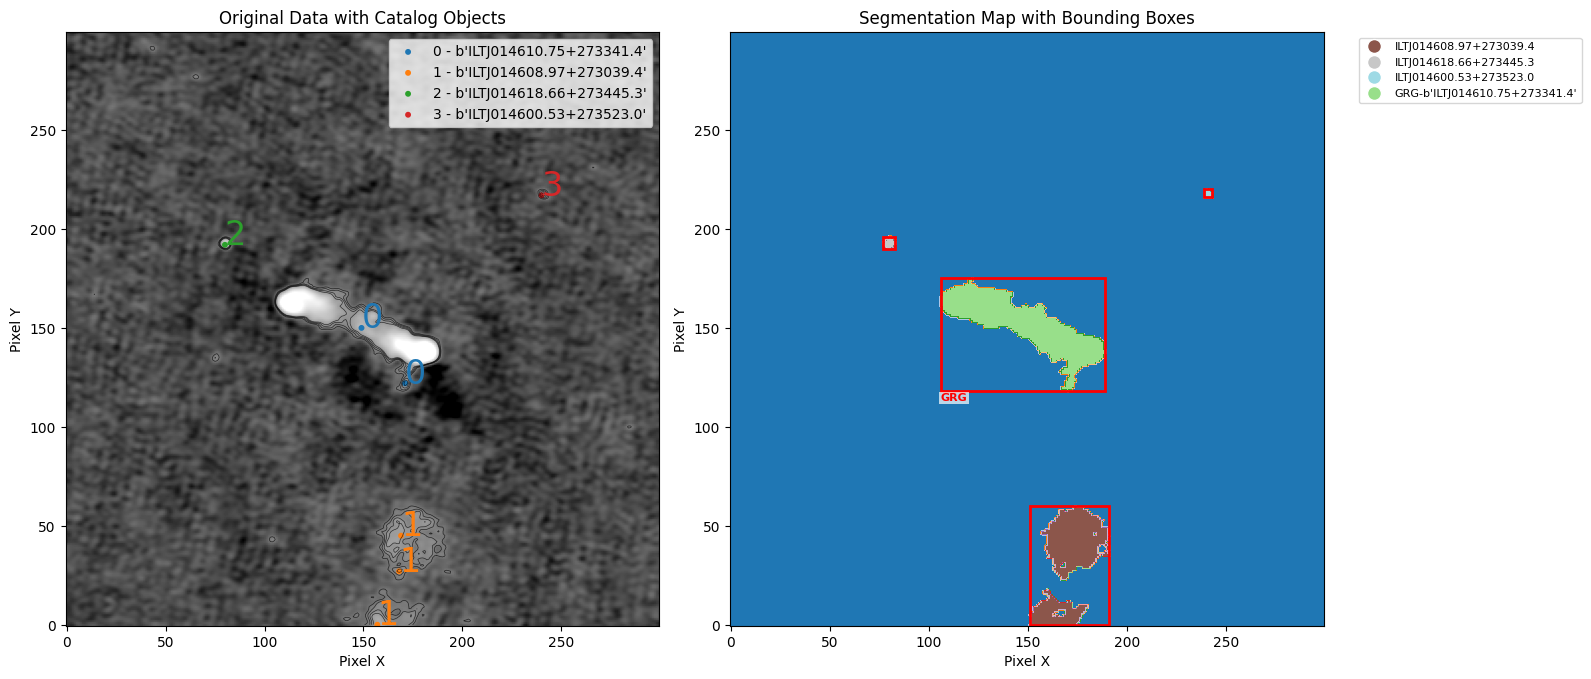

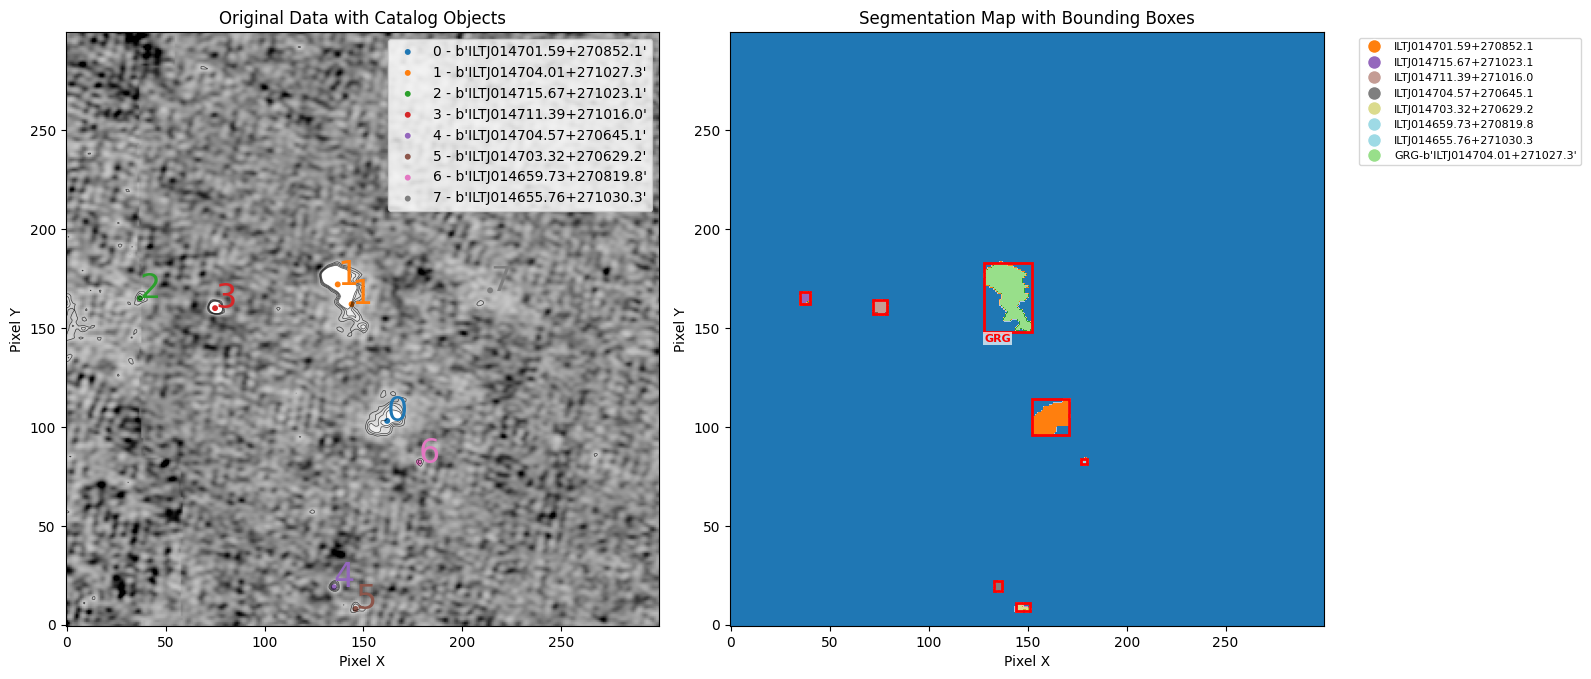

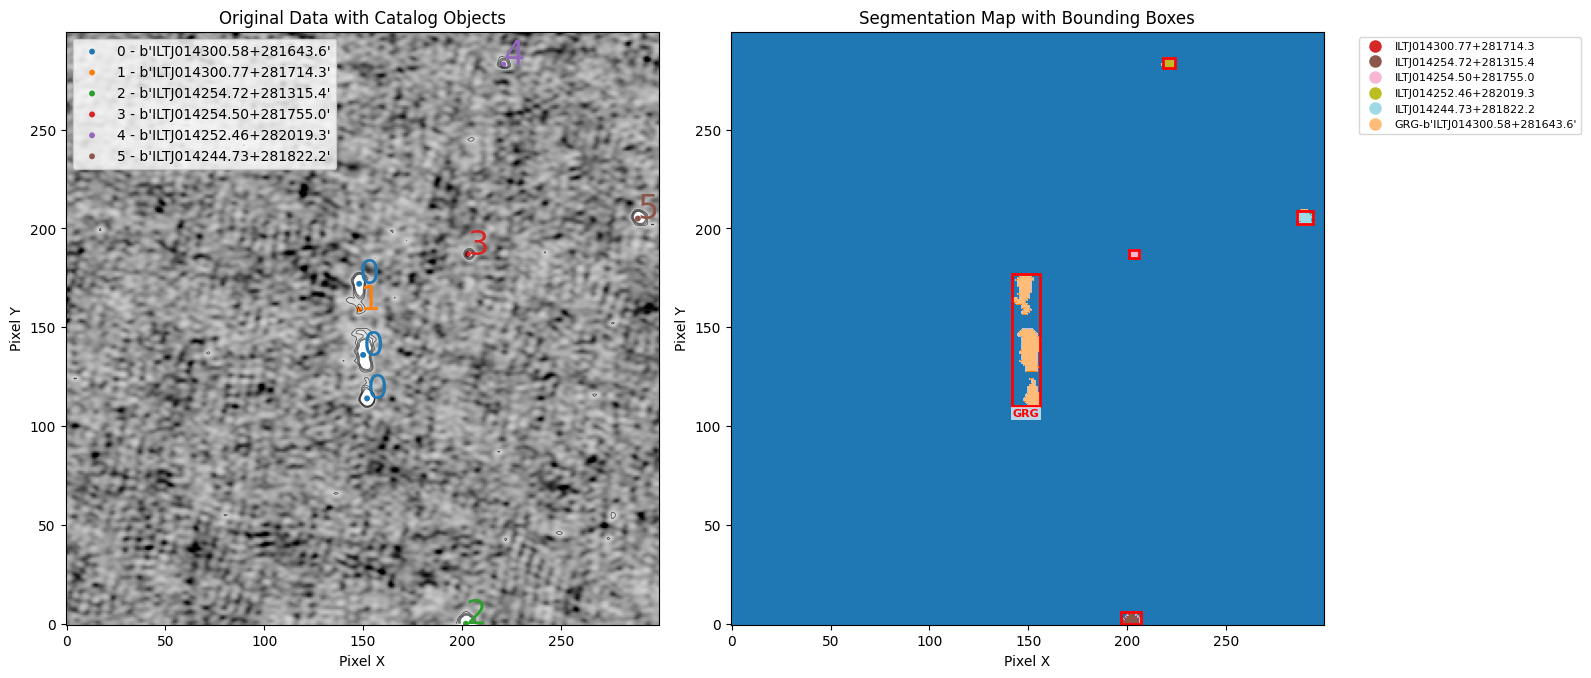

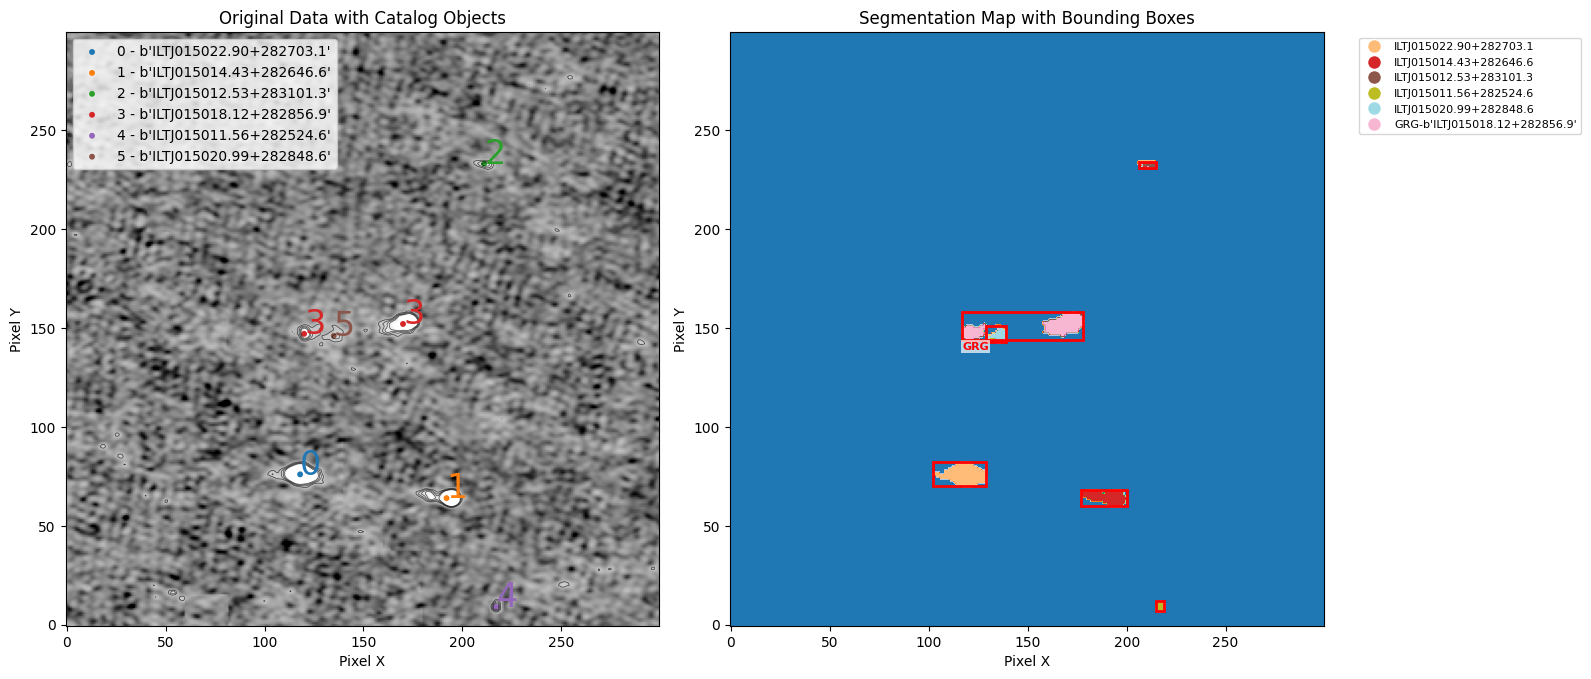

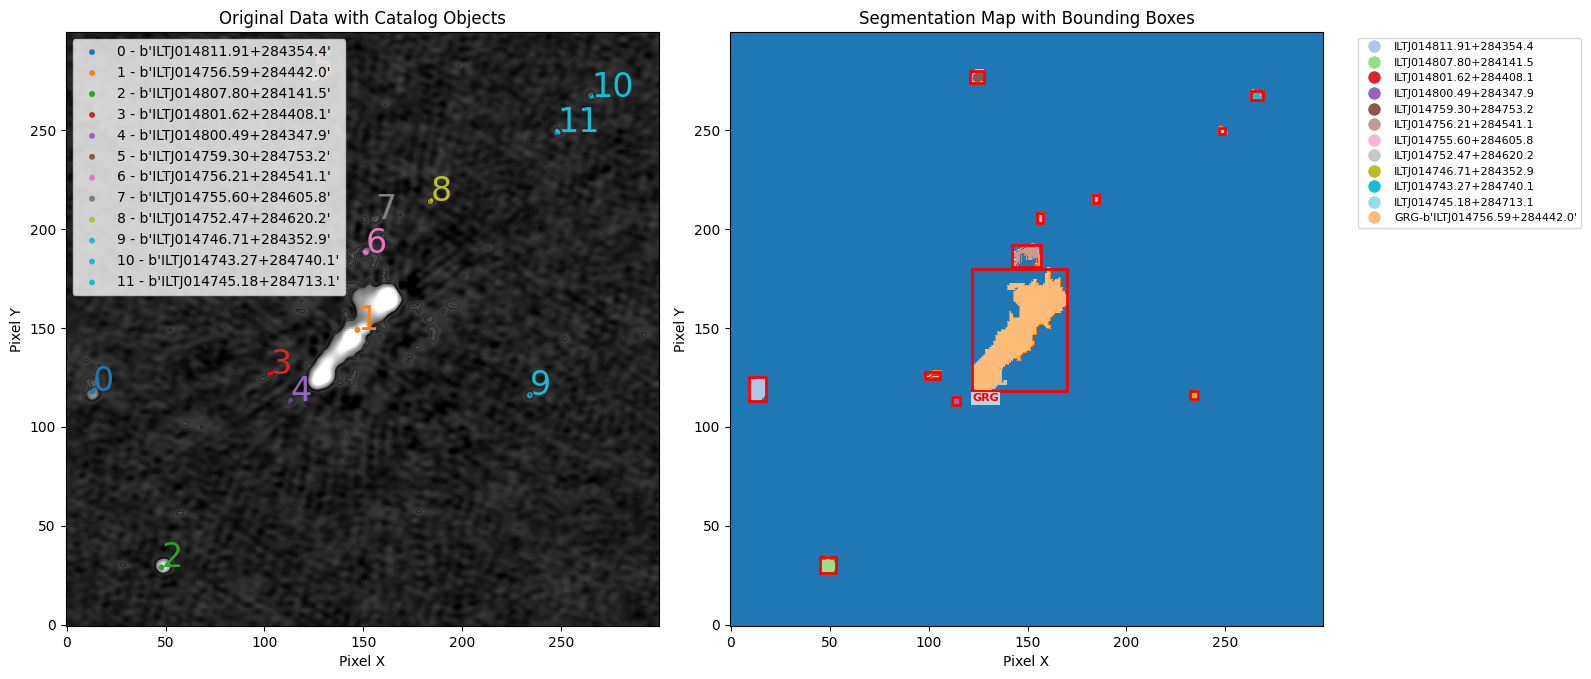

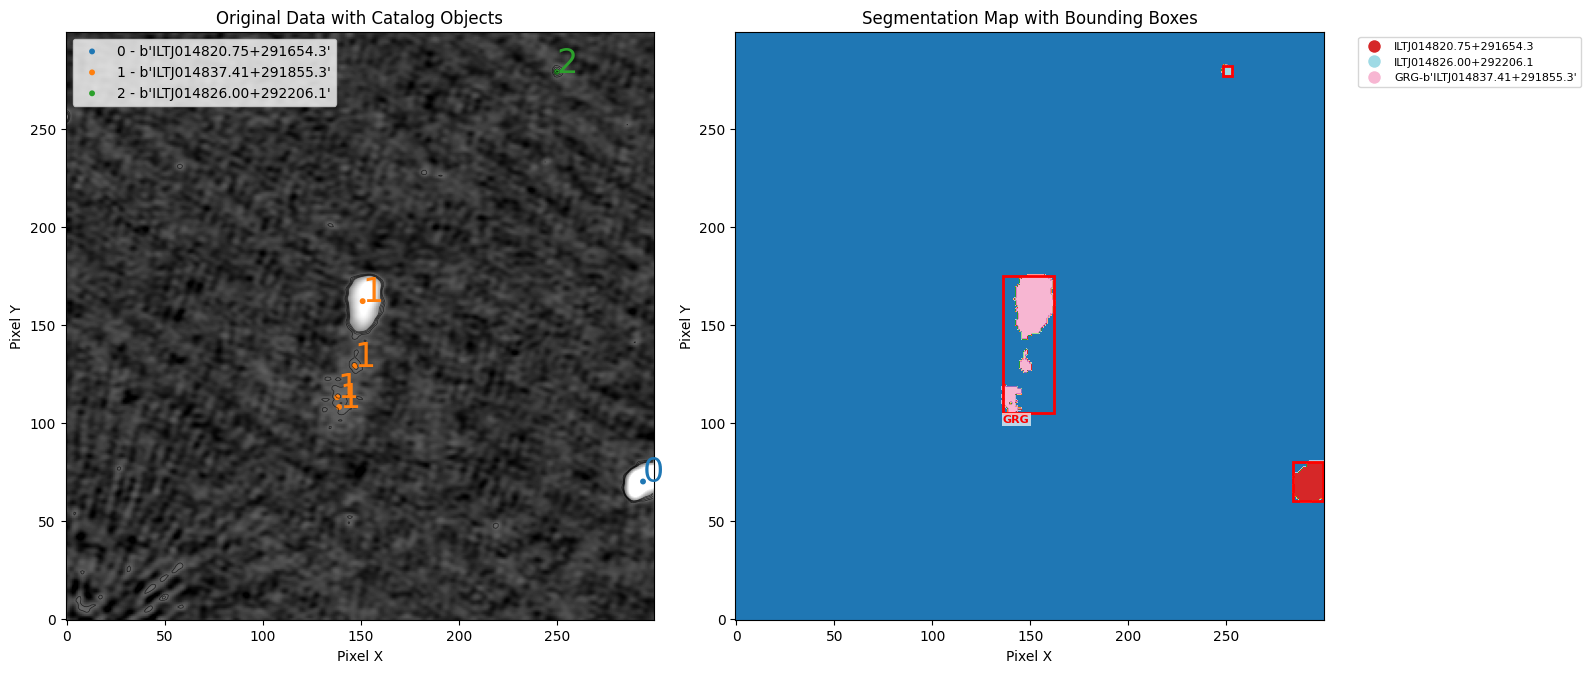

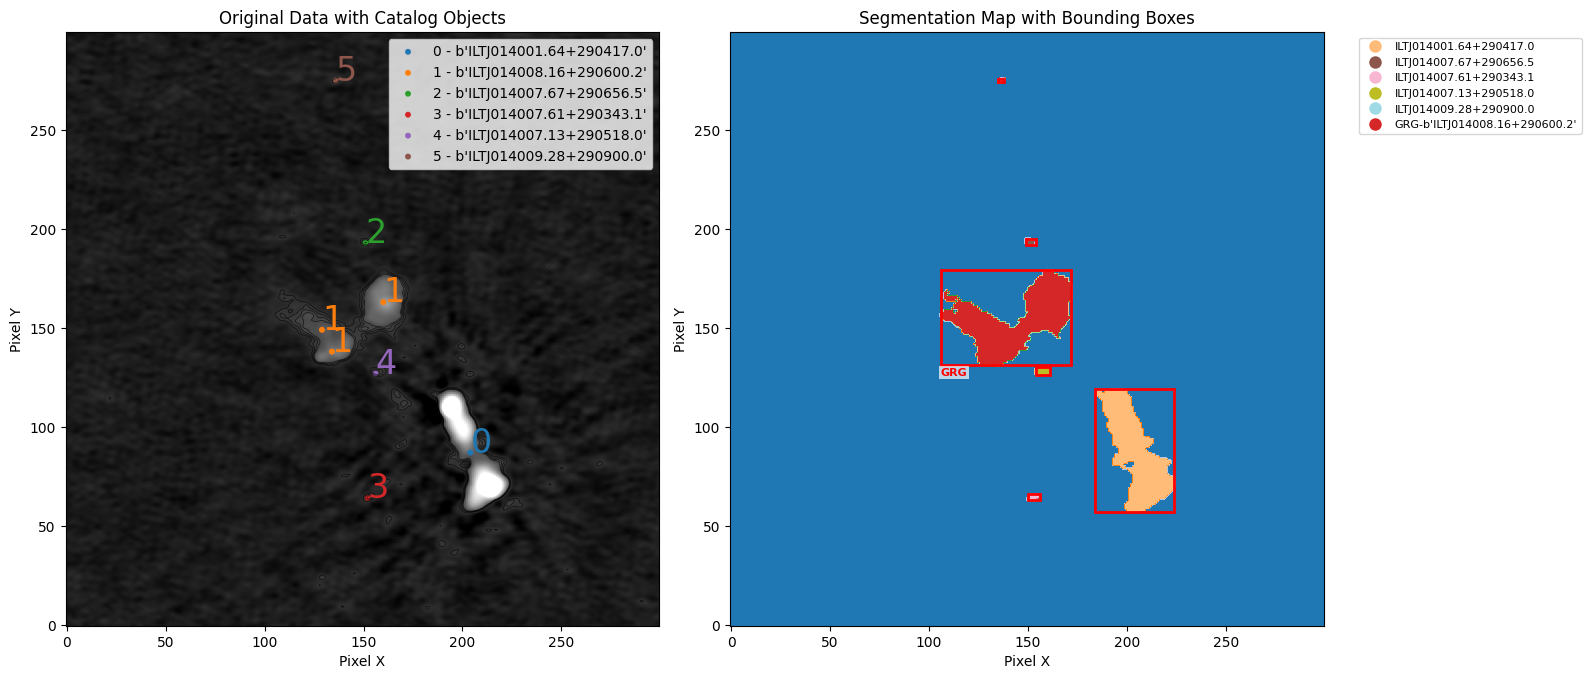

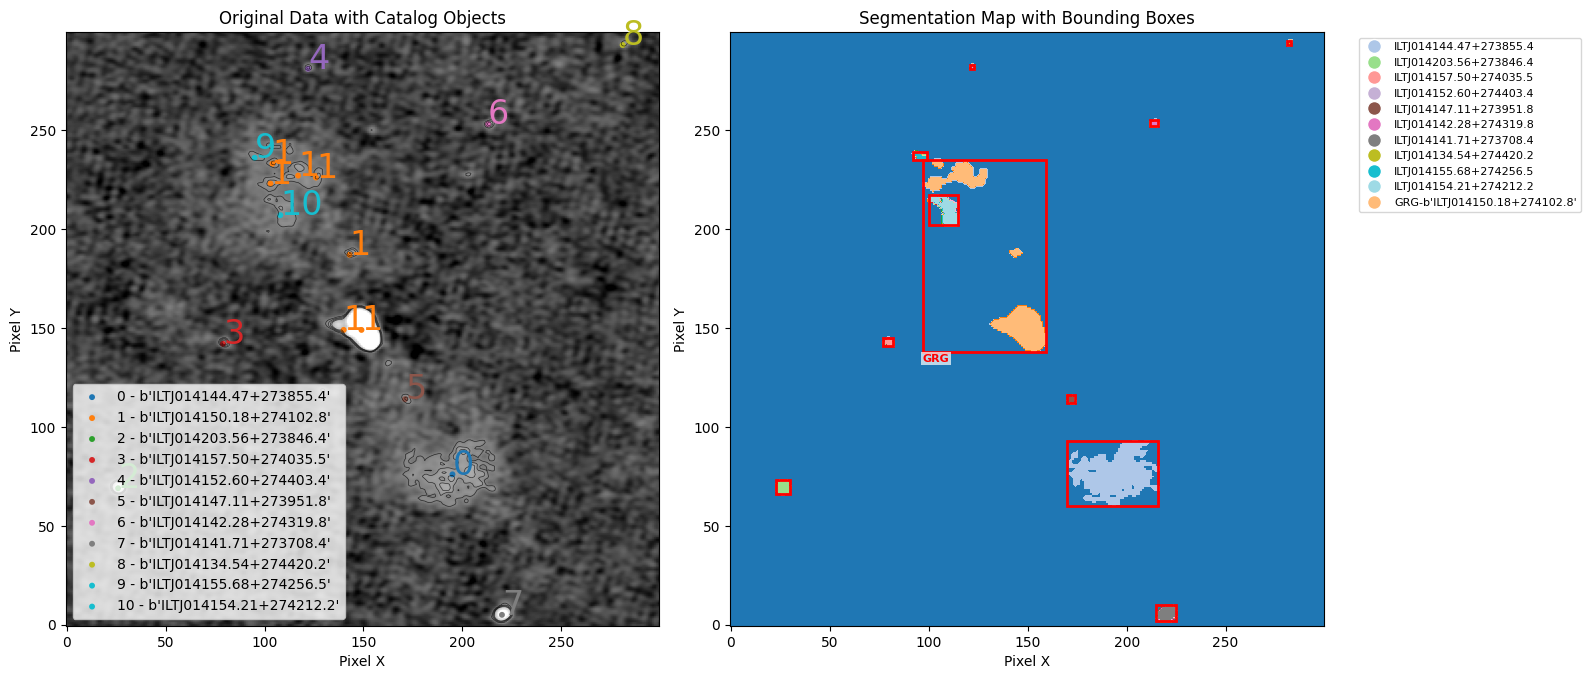

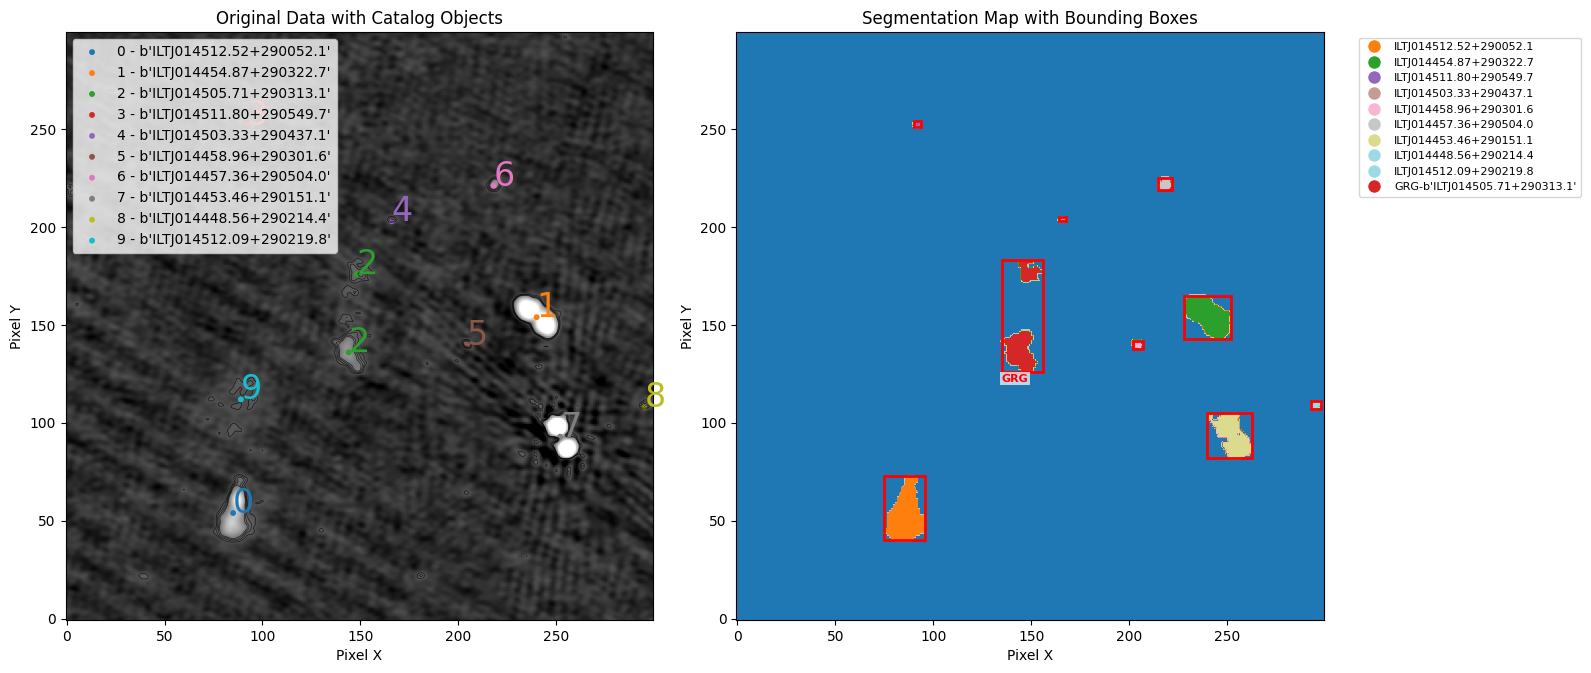

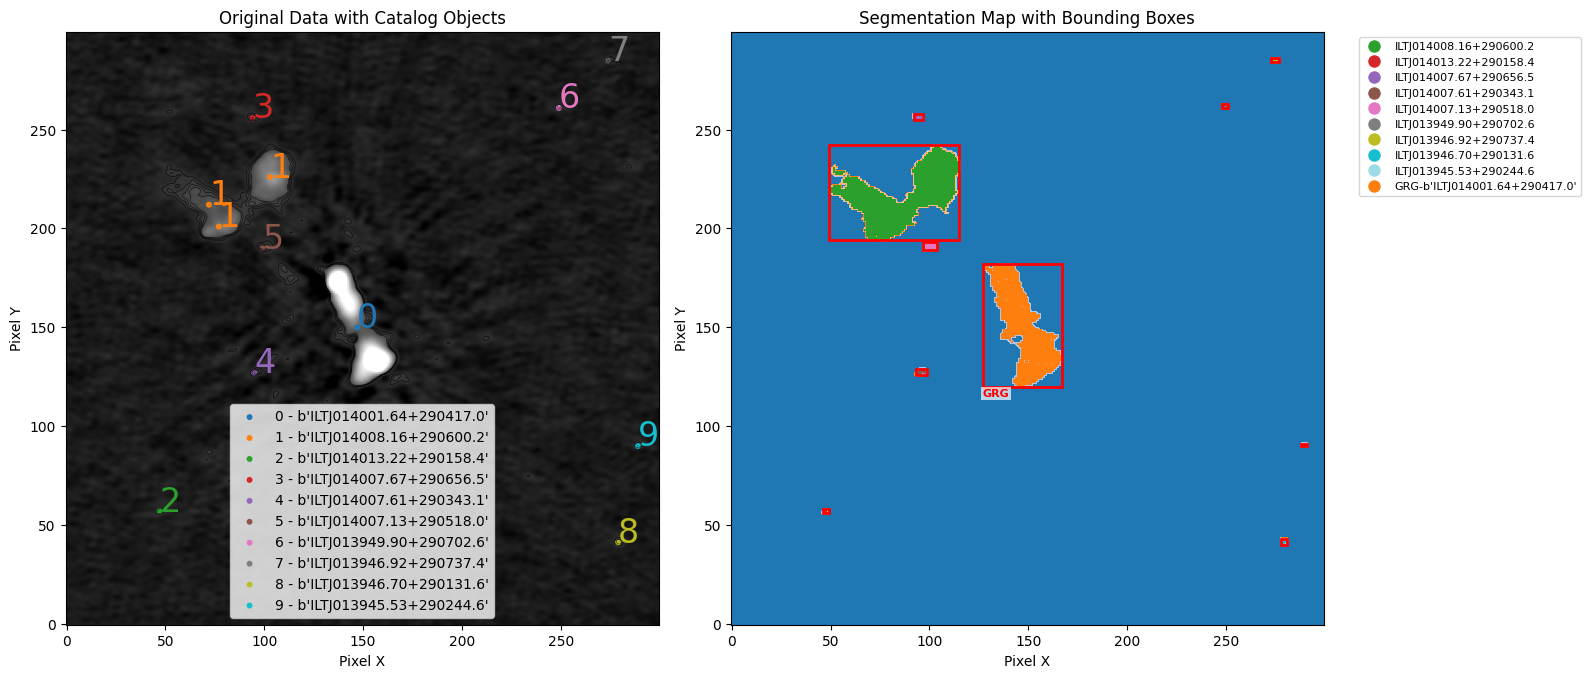

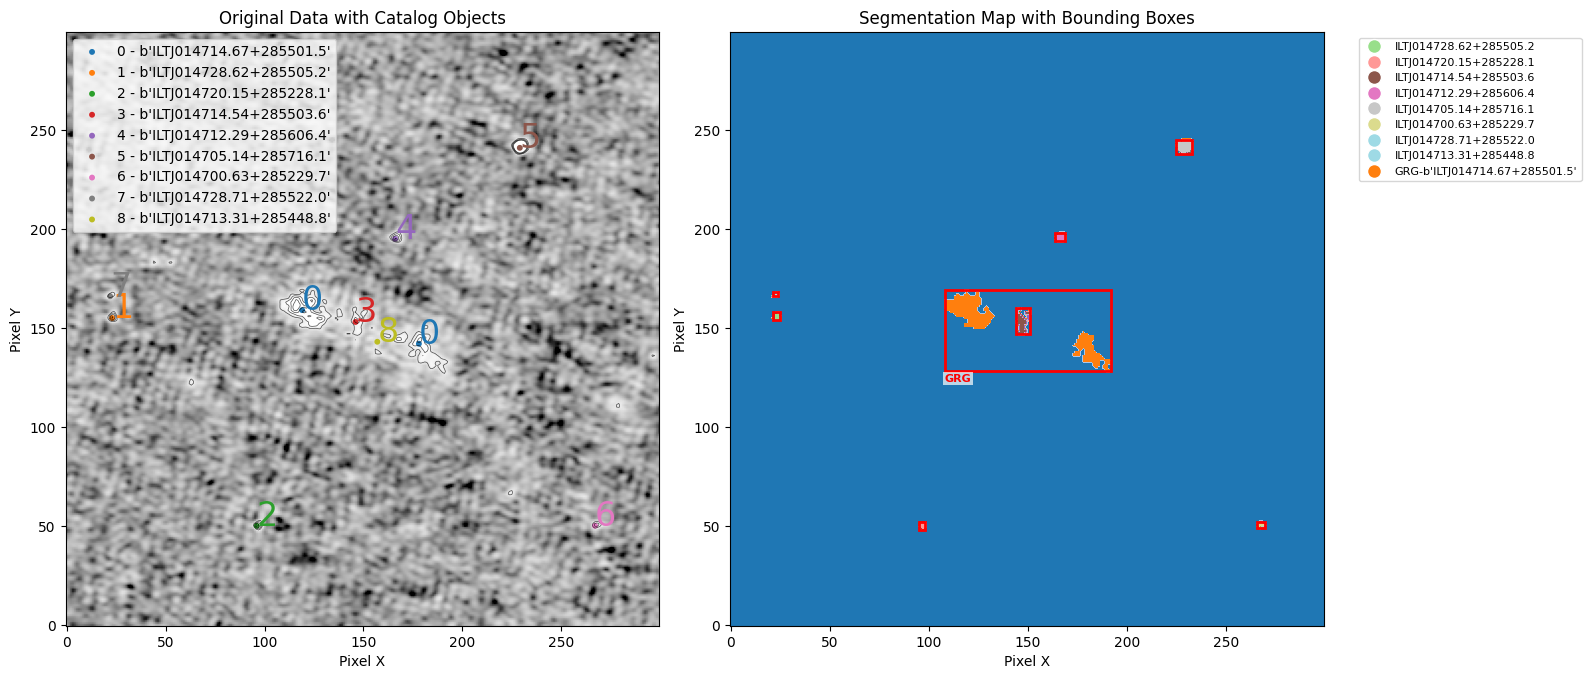

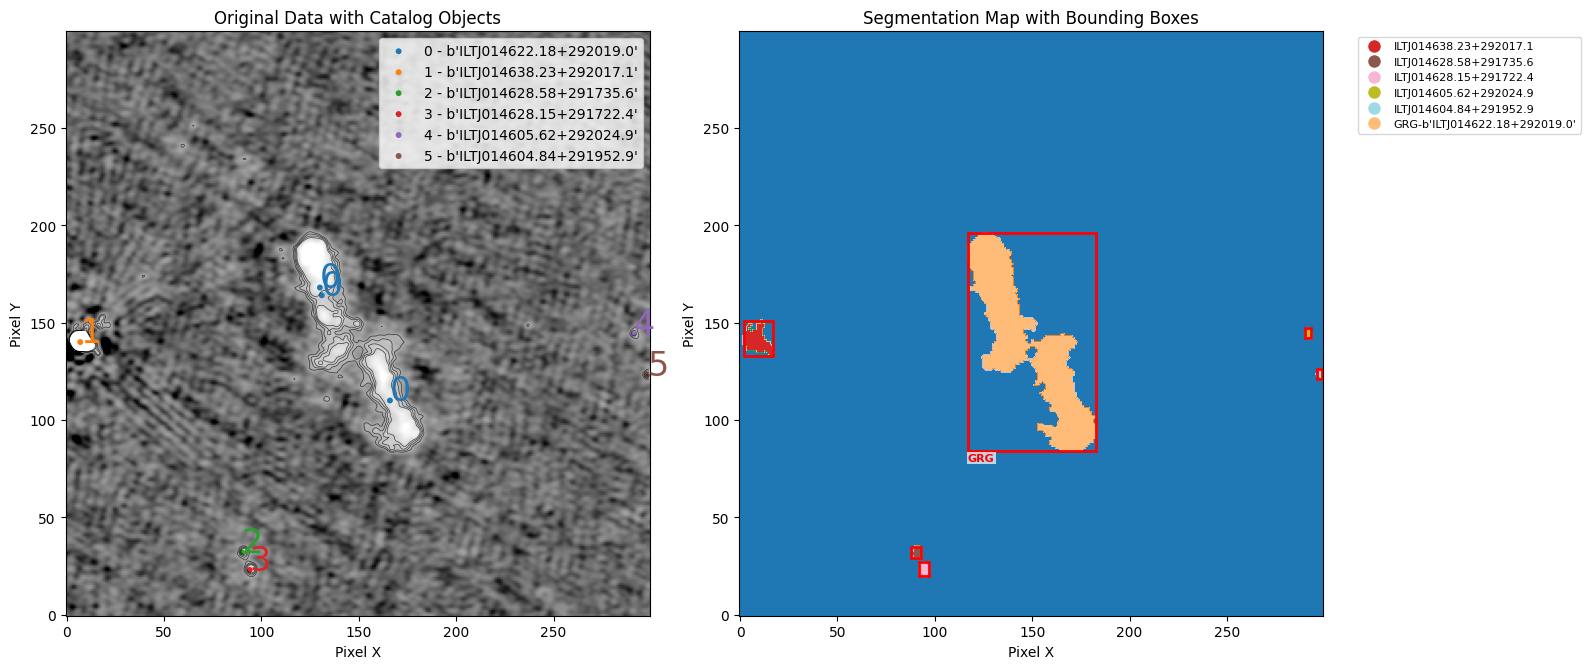

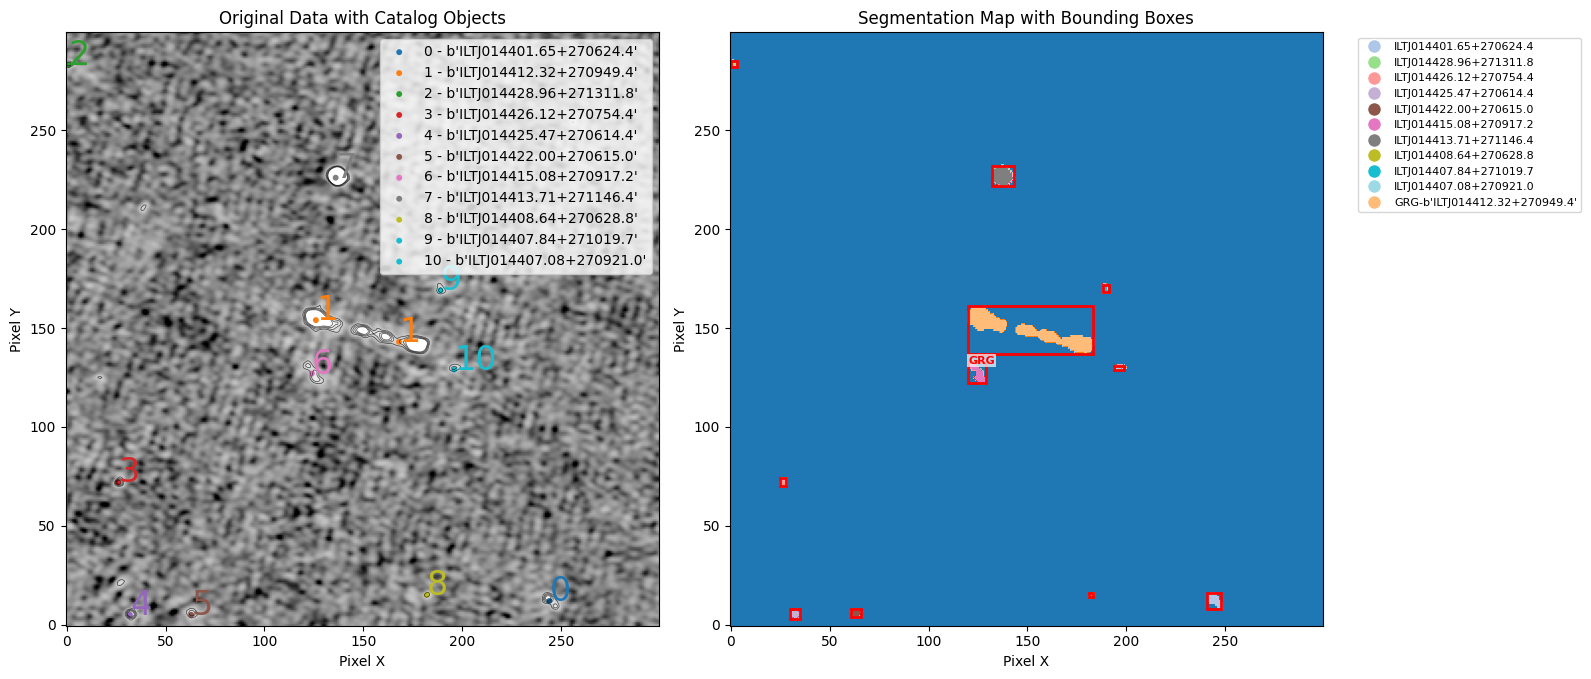

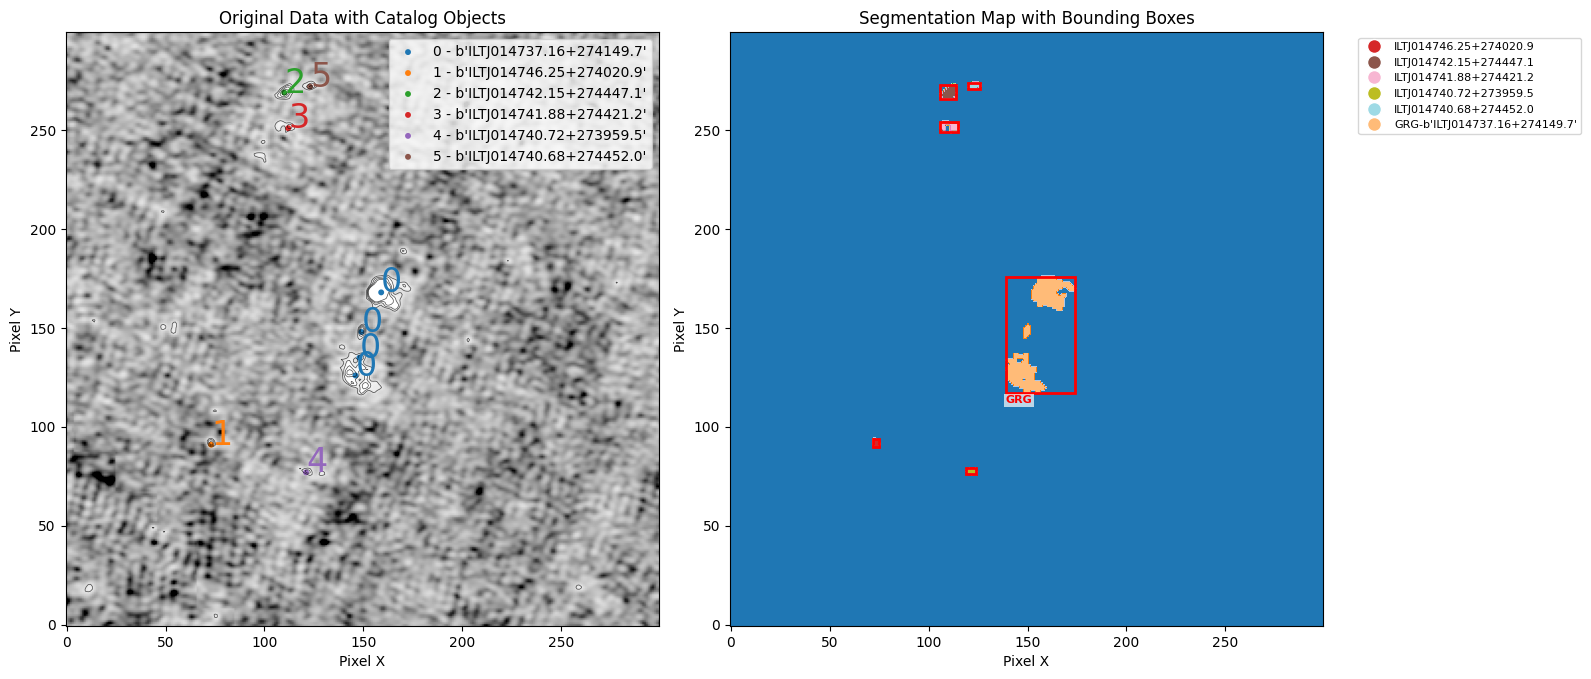

In [17]:
for i in range(len(mosaic_cutouts)):
    annotate_and_show(i)